In [1]:
import jax
import jaxlib
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax.scipy import stats
from dataclasses import dataclass
from jax.scipy.special import gammaln

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
# m1 chip compatible
print(f"jax: {jax.__version__}")
print(f"jaxlib: {jaxlib.__version__}")

jax: 0.2.10
jaxlib: 0.1.60


In [4]:
@dataclass
class GaussGamma:
    mu: float
    beta: float
    a: float
    b: float
        

def generate_data(key, N):
    data = random.normal(key, (N, ))
    data = (data - data.mean()) / data.std()
    return data


def gaussian_gamma_pdf(mu, lmbda, params):
    """
    mu0 = c / beta
    a = 1 + beta / 2
    b = d - c ** 2/ (2 * beta)
    """
    N_part = stats.norm.pdf(mu, loc=params.mu, scale=1 / jnp.sqrt(params.beta * lmbda))
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part


def vb_est_pdf(mu, lmbda, params):
    N_part = stats.norm.pdf(mu, params.mu, 1 / jnp.sqrt(params.beta))
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part

def plot_gauss_exact_vb(ax, exact_params, vb_params, mu_min=-1, mu_max=1,
                        lambda_min=0, lambda_max=2, npoints=500, levels=5):
    
    mu_range = jnp.linspace(mu_min, mu_max, npoints)
    lambda_range = jnp.linspace(lambda_min, lambda_max, npoints)
    proba_exact_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, exact_params)
    proba_vb_space = vb_est_pdf_vmap(mu_range, lambda_range, vb_params)
    
    contour_exact = ax.contour(mu_range, lambda_range, proba_exact_space, colors="tab:orange", levels=levels)
    contour_vb = ax.contour(mu_range, lambda_range, proba_vb_space, colors="tab:blue", levels=levels)
    ax.set_xlabel(r"$\mu$", fontsize=15)
    ax.set_ylabel(r"$\tau$", fontsize=15);
    contour_exact.collections[0].set_label("exact")
    contour_vb.collections[0].set_label("VB")

    ax.legend()
    ax.axis("equal")

In [5]:
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf, in_axes=(0, None, None))
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf_vmap, in_axes=(None, 0, None))

vb_est_pdf_vmap = jax.vmap(vb_est_pdf, in_axes=(0, None, None))
vb_est_pdf_vmap = jax.vmap(vb_est_pdf_vmap, in_axes=(None, 0, None))

In [6]:
mu0, beta, a, b = 0, 2, 5, 6
params = GaussGamma(mu0, beta, a, b)

In [7]:
npoints = 1000
mu_range = jnp.linspace(-2, 2, npoints)
lambda_range = jnp.linspace(0, 2, npoints)

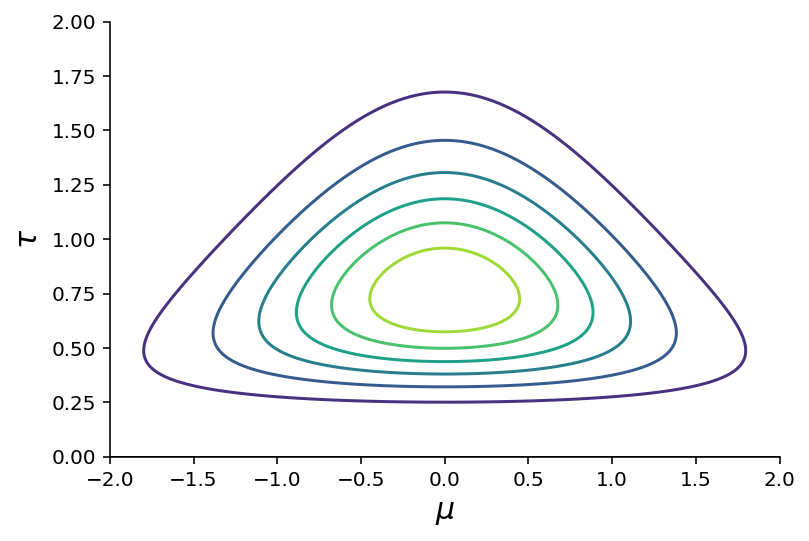

In [8]:
proba_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, params)
plt.contour(mu_range, lambda_range, proba_space)
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

## Univariate gaussian

$$
    q_\mu(\mu) = \mathcal{N}(\mu \vert \bar x, N \mathbb{E}_\tau[\tau])
$$

$$
    q_\tau(\tau) = \text{Gam}\left(\tau \Big\vert \frac{N}{2}, \frac{1}{2}\mathbb{E}_\mu\left[\sum_{n=1}^N(x_n - \mu)^2\right]\right),
$$

where
* $\mathbb{E}_\tau[\tau]^{-1} = \frac{1}{N-1}\sum_{n=1}^N (x_n - \bar x)^2$
* $\mathbb{E}_\mu[\mu] = N \bar{x^2} - N{\bar x}^2 + \frac{N}{\mathbb{E}_\tau[\tau]}$

In [9]:
key = random.PRNGKey(3141)
N = 10
data = generate_data(key, N)

In [10]:
x_bar = jnp.mean(data)
mu_post = jnp.mean(data)
beta_post = N
a_post = N / 2
b_post = jnp.sum((data - mu_post) ** 2) / 2

posterior_params = GaussGamma(mu_post, beta_post, a_post, b_post)

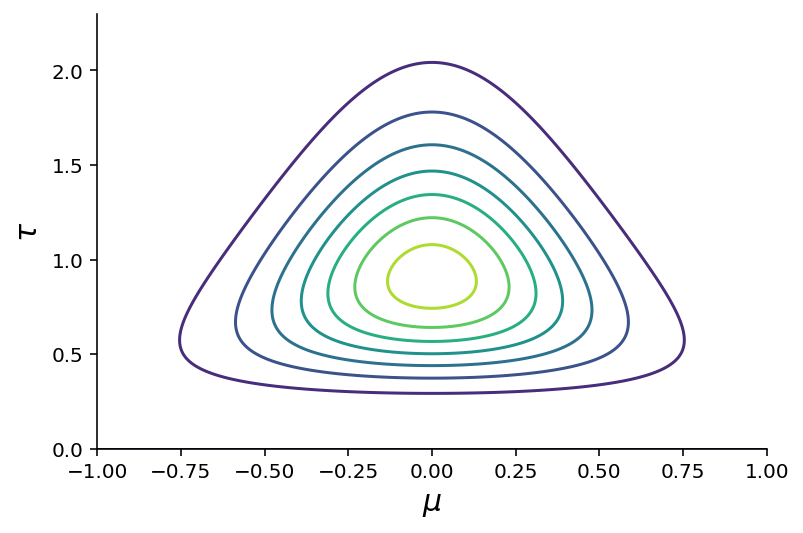

In [11]:
npoints = 500
mu_range = jnp.linspace(-1, 1, npoints)
lambda_range = jnp.linspace(0, 2.3, npoints)
proba_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, params)

proba_post_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, posterior_params)
plt.contour(mu_range, lambda_range, proba_post_space)
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

## All together

In [12]:
def vb_unigauss_learn(data, params_prior, params_init, eps=1e-6):
    """
    Variational Bayes (VB) procedure for estimating the parameters
    of a univariate gaussian distribution
    
    Returns
    -------
    * The VB-estimated parameters
    * History of the estimation of parameters after updating
        the mean and after updating the precision
    """
    N = len(data)
    lower_bound = -jnp.inf
    xbar = jnp.mean(data)
    
    mu0, beta0 = params_prior.mu, params_prior.beta
    a0, b0 = params_prior.a, params_prior.b
    
    muN, betaN = params_init.mu, params_init.beta
    aN, bN = params_init.a, params_init.b
    
    converge = False
    params_hist = []
    while not converge:
        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        # update q_mu
        e_tau = aN / bN
        muN = (beta0 * mu0 + N * xbar) / (beta0 + N)
        betaN = (beta0 + N) * e_tau

        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        # update q_tau
        e_mu = xbar
        e_mu2 = 1 / betaN + muN ** 2
        aN = a0 + (N + 1) / 2
        bN = b0 + beta0 * (e_mu2 + mu0 ** 2 - 2 * mu0 * e_mu) / 2 + (data ** 2 + e_mu2 - 2 * e_mu * data).sum() / 2

        est_params = GaussGamma(muN, betaN, aN, bN)
        params_hist.append(est_params)

        lower_bound_new = - jnp.log(betaN) - gammaln(aN) * jnp.log(bN)
        if abs(lower_bound_new / lower_bound - 1) < eps:
            converge = True
            est_params = GaussGamma(muN, betaN, aN, bN)
            params_hist.append(est_params)
        else:
            lower_bound = lower_bound_new
    
    return est_params, params_hist

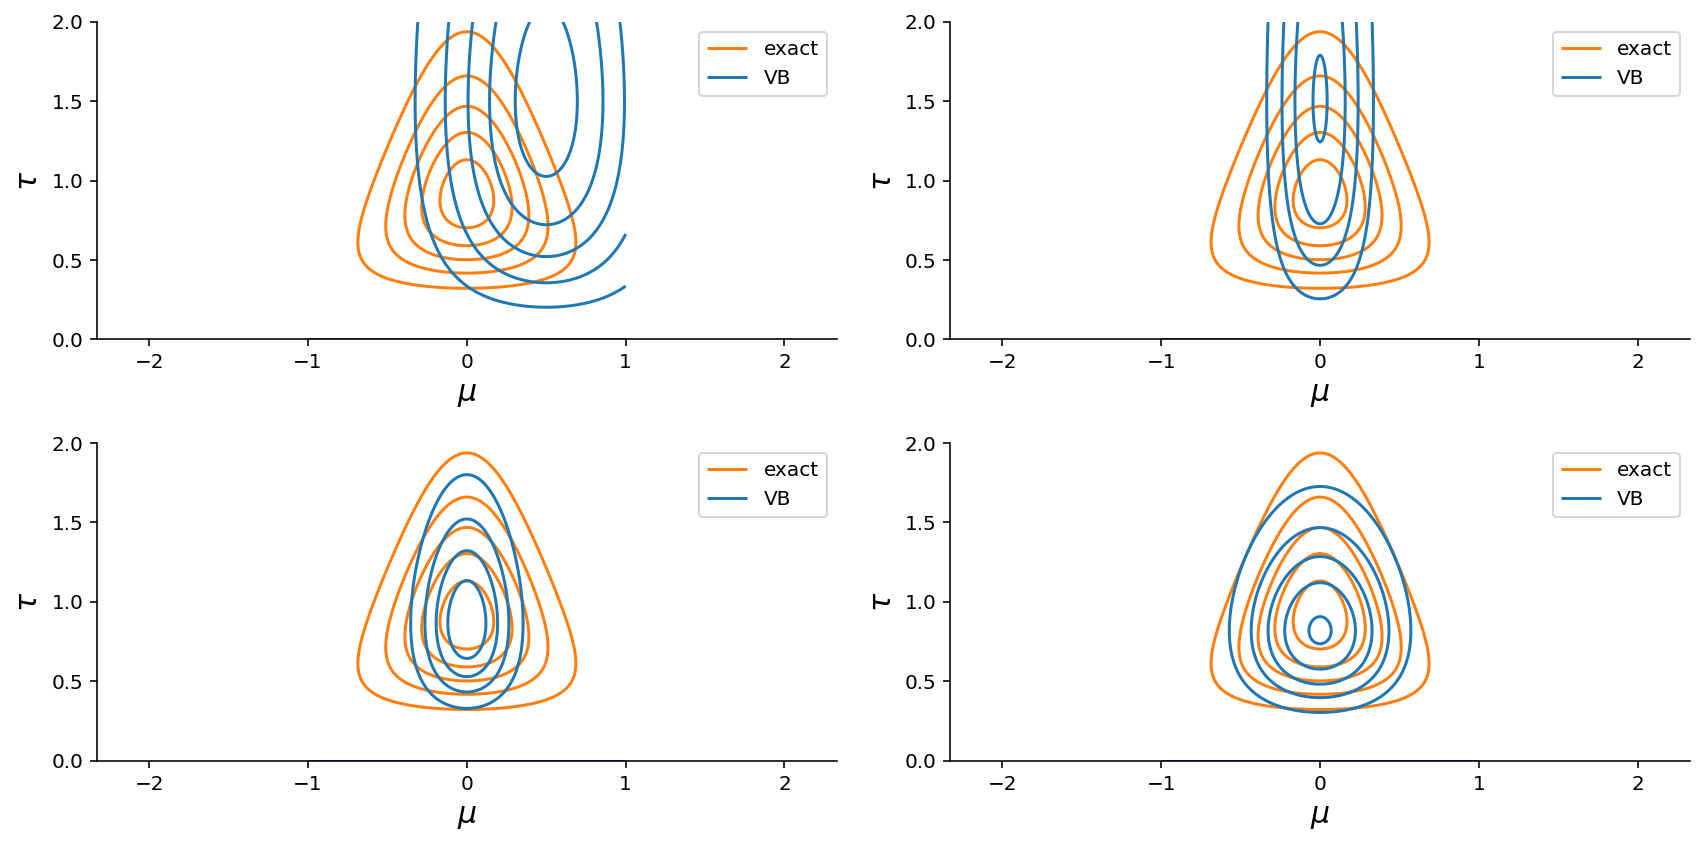

In [13]:
mu0, beta0, a0, b0 = jnp.zeros(4)
params_prior = GaussGamma(mu0, beta0, a0, b0)
params_vb_init = GaussGamma(mu=0.5, beta=5, a=2.5, b=1)

_, params_hist = vb_unigauss_learn(data, params_prior, params_vb_init)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()

# We take the indices of
# 1. our initial estimate, 
# 2. after q_mu update in the first iteration
# 3. after q_tau update in the second iteration
# 4. after convergence
params_ix = [0, 1, 2, -1]
for ix_param, axi in zip(params_ix , ax):
    vb_params = params_hist[ix_param]
    plot_gauss_exact_vb(axi, posterior_params, vb_params)
plt.tight_layout()

## References
* https://github.com/probml/pmtk3/blob/master/demos/unigaussVbDemo.m